# 0: Section Overview

In this section, we will impliment a baseline model. This will provide a basic model against which more complex models can be compared. This comparison will help us to gauge the effectiveness of enhancements or modifications made to the model. Additionally, It sets a standard for evaluating whether more sophisticated models actually provide improvements in predictive performance (in our case, this performance metric is measured as the MSE).

# 1: Necessary Imports

In [57]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import random
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import Lasso

# 2: Data Access

We will access the data in the same way throughout the project.

In [58]:
test_filepath = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\Assessment_1\Train_and_Test_data\test.xlsx" # Enter your file path for the train data
train_filepath = r"C:\Users\markm\OneDrive\Documents\University\Year 4\dst\GitHub\Assessment_1\Train_and_Test_data\train.xlsx" # Enter your file path for the test data

test_data = pd.read_excel(test_filepath)
train_data = pd.read_excel(train_filepath)

# 3: Implimenting the baseline model: Linear Regression

Initally, let us train the model on the entire training data. Note that we don't require the first 4 columns (date, iso_code, continent and location). Therefore, the first thing we will do is remove these columns.

In [59]:
train_data_string_cols_rem = train_data.iloc[:, 4:]
test_data_string_cols_rem = test_data.iloc[:, 4:]

print(train_data_string_cols_rem.columns)

print(test_data.shape)
print(train_data.shape)
# iso_codes = test_data['iso_code'].unique()
# random_iso_code = random.choice(iso_codes)
# country_to_display = test_data[test_data['iso_code'] == random_iso_code]
# print(country_to_display)


Index(['Mean_Stringency_Index', 'CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index',
       'days_since', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths',
       'reproduction_rate'],
      dtype='object')
(32431, 14)
(134618, 14)


### Training Data

We will select the relevant columns for our particular model, these being the dependent variable, 'reproduction_rate', and all the covariates, these being 'mean_stringency','CH Index', 'Gov Resp Index', 'Econ Sup Index' and 'days_since'. We also choose to remove any rows with missing values. Later on in the project we will evaluate how we can go about using those rows with missing information.

In [60]:
train_data_string_cols_rem = train_data.iloc[:, 4:]
test_data_string_cols_rem = test_data.iloc[:, 4:]
covariates = ['Mean_Stringency_Index','CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index','days_since','total_cases','total_deaths','new_cases','new_deaths']
covariates_and_repr = covariates + ['reproduction_rate']
train_data_filtered = train_data_string_cols_rem[covariates_and_repr]
X_train = train_data_filtered[covariates]
y_train = train_data_filtered['reproduction_rate']
print()
print(X_train.shape)
print(len(y_train))



(134618, 9)
134618


### Testing Data

We impliment the same filtering as we did with the training data.

In [61]:
test_data_filtered = test_data_string_cols_rem[covariates_and_repr]
X_test = test_data_filtered[covariates]
y_test = test_data_filtered[['reproduction_rate']]
print()
print(X_test.shape)
print(len(y_test))


(32431, 9)
32431


In [67]:
linear_model = LinearRegression()

# Fit the model on the training data
linear_model.fit(X_train, y_train)

print(X_test)


# Make predictions on the test data
y_pred = linear_model.predict(X_test)

print("y_pred shape:", y_pred.shape)
# Calculate Mean Squared Error (MSE) on the test data
mse = mean_squared_error(y_test, y_pred)
R_squared = linear_model.score(X_test, y_test)

# Print the MSE result
print(f'Mean Squared Error on the test data: {mse:.4f}')
print(f'R^2: {R_squared:.4f}')


       Mean_Stringency_Index  CH_Index  Gov_Resp_Index  Econ_Sup_Index  \
0                      45.37     41.07           35.94             0.0   
1                      45.37     41.07           35.94             0.0   
2                      45.37     41.07           35.94             0.0   
3                      45.37     41.07           35.94             0.0   
4                      62.04     54.17           47.40             0.0   
...                      ...       ...             ...             ...   
32426                  11.11     21.43           21.88            25.0   
32427                  11.11     21.43           21.88            25.0   
32428                  11.11     21.43           21.88            25.0   
32429                  11.11     21.43           21.88            25.0   
32430                  11.11     21.43           21.88            25.0   

       days_since  total_cases  total_deaths  new_cases  new_deaths  
0              74           86           

#### Addressing a TypeError

In [63]:
print(type(y_test))  # Should be pandas.Series or numpy.ndarray
print(type(y_pred))  # Should be pandas.Series or numpy.ndarray

y_test = y_test.squeeze()  # Convert DataFrame to Series
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


# 4: Cross-validation

Since we have no hyperparameters to tune in the Baseline Linear model, Cross-validation will not be required. Hence we will not impliment it here.

# 5: Visualising our performance metric for the baseline model

## 5.1: Scatter Plot

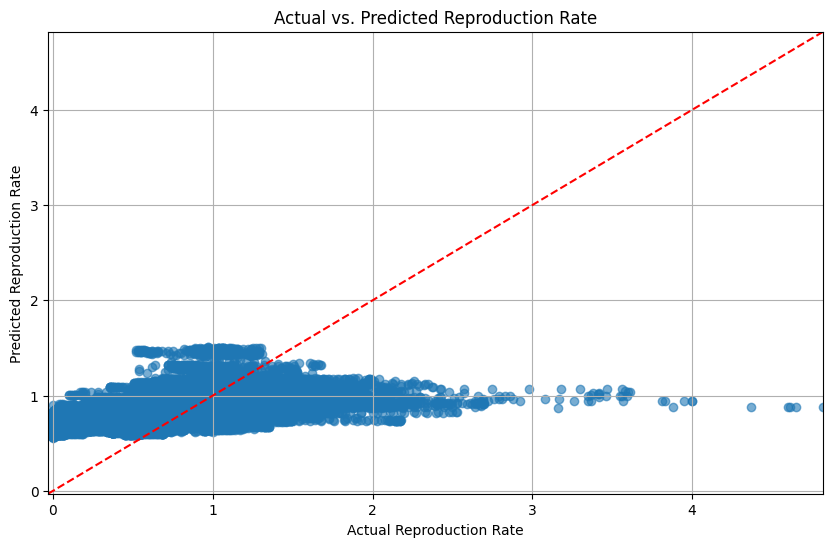

In [64]:

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Line of perfect prediction
plt.title('Actual vs. Predicted Reproduction Rate')
plt.xlabel('Actual Reproduction Rate')
plt.ylabel('Predicted Reproduction Rate')
plt.xlim([y_test.min(), y_test.max()])
plt.ylim([y_test.min(), y_test.max()])
plt.grid()
plt.show()

The above plot is a scatter plot that plots actual reproduction rate against the linear model's prediction for that particular row in the dataset. Essentially, better performing models will have more points closer to or on the red line (where actual reproduction rate = predicted reproduction rate) however whilst there are points near this line, it is clear the model is making errors as there are lots of points above and below the red line.


## 5.2: Residuals Plot

A residuals plot shows the residuals (the difference between actual and predicted values) on the y-axis against the predicted values on the x-axis. This can help identify any patterns in the errors.

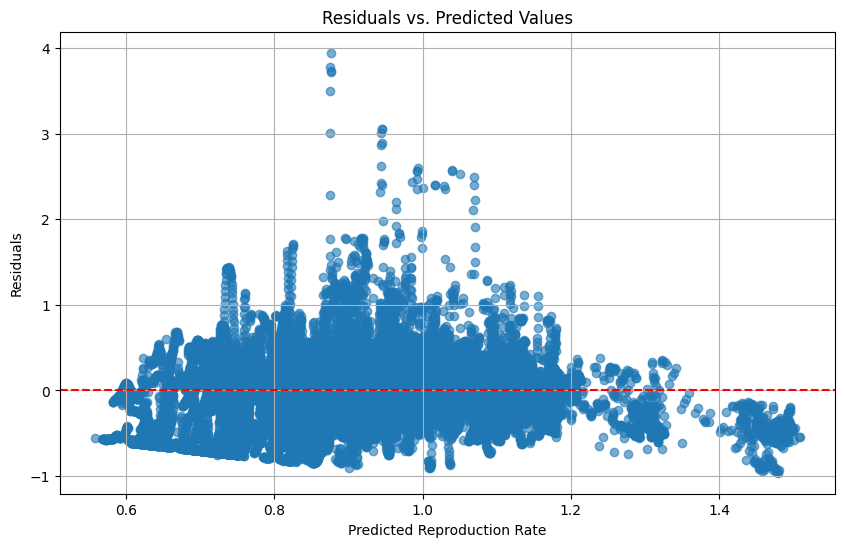

In [80]:
# Calculate residuals
residuals = y_test - y_pred

# Create a residuals plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')  # Line at 0
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Reproduction Rate')
plt.ylabel('Residuals')
plt.grid()
plt.show()


This plot shows similar information to the previous plot however now we are directly plotting the residual values of the baseline model. Since we have a large number of data points, it is difficult to see how densly populated the residuals are around the line y = 0. We can use the hexbin function in the matplot library to overlay a heatmap on the residuals plot which allows us to see where the data points are more densely populated.


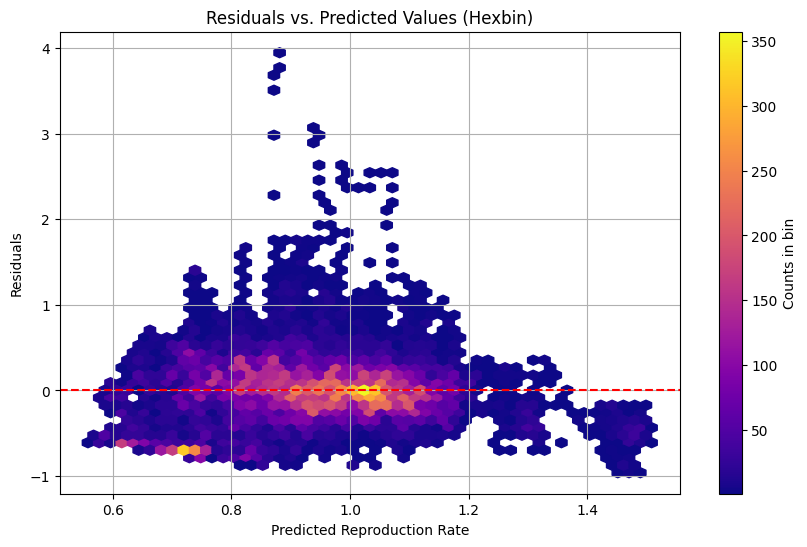

In [81]:
# Calculate residuals
residuals = y_test - y_pred

# Create a hexbin plot with a different color scheme
plt.figure(figsize=(10, 6))
plt.hexbin(y_pred, residuals, gridsize=50, cmap='plasma', mincnt=1)  # Use 'plasma' color map
plt.colorbar(label='Counts in bin')  # Show color bar
plt.axhline(0, color='red', linestyle='--')  # Line at 0
plt.title('Residuals vs. Predicted Values (Hexbin)')
plt.xlabel('Predicted Reproduction Rate')
plt.ylabel('Residuals')
plt.grid()
plt.show()


Here, we can see that the most densly populated areas are where residuals are closer to 0 as that is where the lighter areas are shown on the graph. However, let us zoom in closer on the central residuals to get tighter limits on the residuals axis with a smaller intervals displayed on the y-axis.

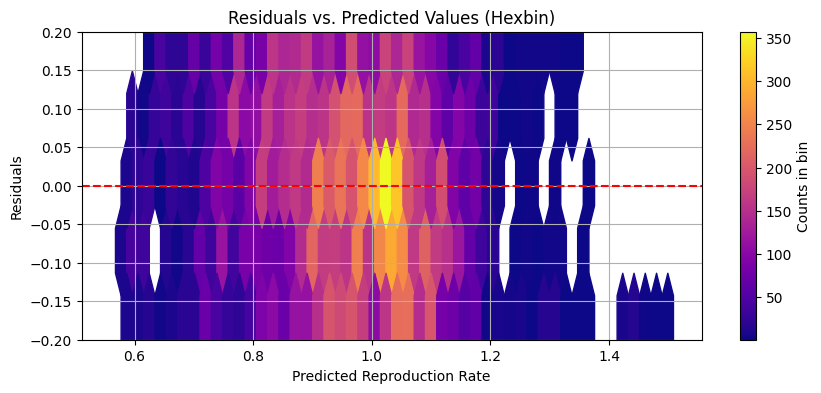

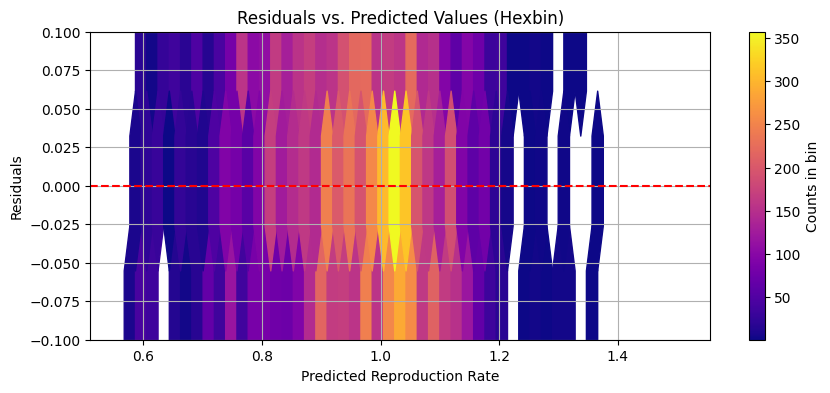

In [94]:
import matplotlib.pyplot as plt

# Create a hexbin plot with a different color scheme
plt.figure(figsize=(10, 4))  # Size adjustment
plt.hexbin(y_pred, residuals, gridsize=50, cmap='plasma', mincnt=1)  # Use 'plasma' color map
plt.colorbar(label='Counts in bin')  # Show color bar
plt.axhline(0, color='red', linestyle='--')  # Line at 0
plt.title('Residuals vs. Predicted Values (Hexbin)')
plt.xlabel('Predicted Reproduction Rate')
plt.ylabel('Residuals')

# Set tighter limits for y-axis to focus on smaller residuals
plt.ylim(-0.2, 0.2)  # Adjust the limits for more zoom
plt.grid()
plt.show()


# Create a hexbin plot with a different color scheme
plt.figure(figsize=(10, 4))  # Size adjustment
plt.hexbin(y_pred, residuals, gridsize=50, cmap='plasma', mincnt=1)  # Use 'plasma' color map
plt.colorbar(label='Counts in bin')  # Show color bar
plt.axhline(0, color='red', linestyle='--')  # Line at 0
plt.title('Residuals vs. Predicted Values (Hexbin)')
plt.xlabel('Predicted Reproduction Rate')
plt.ylabel('Residuals')

# Set tighter limits for y-axis to focus on smaller residuals
plt.ylim(-0.1, 0.1)  # Adjust the limits for more zoom
plt.grid()
plt.show()



The plot shows that the majority of residuals are within the range of -0.05 to 0.05. This concentration of points near zero suggests that for these predictions, the model’s predicted values are within this range of the actual values. This suggests that, whilst the model is making errors, The model does not tend to frequently make large deviations from the actual values. However, it is important to note that if the values of 
predicted reproduction_rate and actual_reproduction_rate are relatively small, then the residuals, which are the absolute differences between them, may also be small simply due to the scale.

## 5.3: Histogram of Residuals

the histogram of the residuals can show the distribution of errors.

When we say that the residuals should be normally distributed around zero, we mean that:
Most of the errors (residuals) should be small and close to zero.
Errors should have a symmetrical distribution, with equal occurrences of positive and negative errors.
What This Implies:

If the residuals are normally distributed around zero, it suggests that:
The model is well-fitted to the data.
There is no systematic bias in the predictions. For instance, if the model consistently overestimates or underestimates the true values, this would show up as a skewed distribution of residuals, rather than a symmetric one around zero.
, which should ideally be normally distributed around zero if the model is well-fitted.

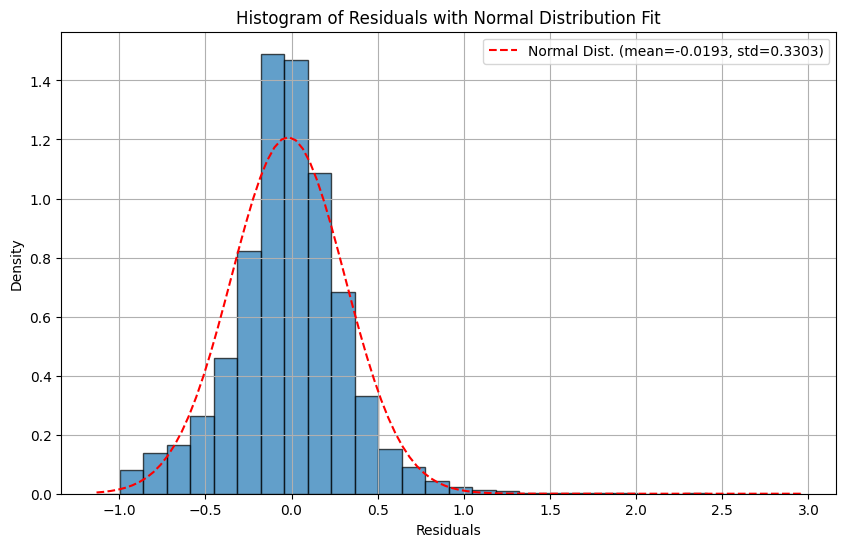

In [53]:

# Assuming you have already calculated residuals

# Calculate the mean and standard deviation of residuals
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

# Generate values for the normal distribution curve
x = np.linspace(min(residuals), max(residuals), 100)  # 100 values between the min and max of residuals
normal_dist = stats.norm.pdf(x, mean_residuals, std_residuals)  # Probability density function of the normal distribution

# Create a histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, density=True, edgecolor='black', alpha=0.7)  # Use density=True to normalize the histogram
plt.title('Histogram of Residuals with Normal Distribution Fit')
plt.xlabel('Residuals')
plt.ylabel('Density')  # Changing to density instead of frequency

# Plot the normal distribution curve
plt.plot(x, normal_dist, 'r--', label=f'Normal Dist. (mean={mean_residuals:.4f}, std={std_residuals:.4f})')

# Add grid and legend
plt.grid(True)
plt.legend()
plt.show()


# 6: Evaluating the model performance



## 6.1: Feature importance with regularization 

In [50]:
coefficients = pd.DataFrame(linear_model.coef_, X_train.columns, columns=['Coefficient'])
coefficients['Absolute Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Absolute Coefficient', ascending=False)

print(coefficients)

                        Coefficient  Absolute Coefficient
Gov_Resp_Index         2.216495e+00          2.216495e+00
CH_Index              -1.931886e+00          1.931886e+00
Econ_Sup_Index        -2.763285e-01          2.763285e-01
Mean_Stringency_Index -3.465247e-03          3.465247e-03
days_since            -3.414299e-04          3.414299e-04
new_deaths            -1.384598e-05          1.384598e-05
total_deaths           1.687026e-07          1.687026e-07
new_cases              1.441729e-08          1.441729e-08
total_cases            5.904141e-09          5.904141e-09


In [51]:
lasso_model = Lasso(alpha=0.1)  # Adjust alpha for regularization strength
lasso_model.fit(X_train, y_train)

lasso_coefficients = pd.DataFrame(lasso_model.coef_, X_train.columns, columns=['Coefficient'])
lasso_coefficients['Absolute Coefficient'] = lasso_coefficients['Coefficient'].abs()
lasso_coefficients = lasso_coefficients.sort_values(by='Absolute Coefficient', ascending=False)

print(lasso_coefficients)


                        Coefficient  Absolute Coefficient
CH_Index               2.813578e-03          2.813578e-03
Econ_Sup_Index         8.222872e-04          8.222872e-04
Gov_Resp_Index         4.708249e-04          4.708249e-04
days_since            -2.739730e-04          2.739730e-04
new_deaths            -1.282647e-05          1.282647e-05
total_deaths           1.307603e-07          1.307603e-07
new_cases              1.443762e-08          1.443762e-08
total_cases            6.479011e-09          6.479011e-09
Mean_Stringency_Index -0.000000e+00          0.000000e+00


## References